# [A coupled PO₄–POP model](@id P-model)

## In this tutorial we will explicitly simulate 2 tracers whose distributions control and feed back on each other.

 We consider a simple model for the cycling of phosphorus with 2 state variables consisting of phosphate (PO₄) AKA dissolved inorganic phosphorus (DIP) and particulate organic phosphorus (POP).
 The dissolved phases are transported by advection and diffusion whereas the particulate phase sinks rapidly down the water column without any appreciable transport by the circulation.

 The governing equations that couple the 3D concentration fields of DIP and POP, denoted $x_\mathsf{DIP}$ and $x_\mathsf{POP}$, respectively, are:

 $$\left[\frac{\partial}{\partial t} + \nabla \cdot (\boldsymbol{u} + \mathbf{K}\nabla )\right] x_\mathsf{DIP} = -U(x_\mathsf{DIP}) + R(x_\mathsf{POP}),$$

 and

 $$\left[\frac{\partial}{\partial t} + \nabla \cdot \boldsymbol{w}\right] x_\mathsf{POP} = U(x_\mathsf{DIP}) - R(x_\mathsf{POP}).$$

 The $\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \nabla \right]$ and $\nabla \cdot \boldsymbol{w}$ operators represent the ocean circulation and the sinking of particles, respectively.
 ([Tracer transport operators are described in the documentation](@ref tracer-transport-operators).)

 The function $U$ represents the biological uptake of DIP by phytoplankton, which we model here as

 $$U(x_\mathsf{DIP}) = \frac{x_\mathsf{DIP}}{\tau_\mathsf{DIP}} \, \frac{x_\mathsf{DIP}}{x_\mathsf{DIP} + k} \, (z < z_0),$$

 with the timescale, $\tau$, the half-saturation rate $k$, and the depth $z_0$ as parameters.

 The function $R$ defines the remineralization rate of POP, which converts POP back into DIP.
 For the remineralization, we simply use a linear rate constant, i.e.,

 $$R(x_\mathsf{POP}) = \frac{x_\mathsf{POP}}{\tau_\mathsf{POP}}.$$



 We start by telling Julia we want to use the AIBECS and the OCIM0.1 circulation for DIP.

In [1]:
using AIBECS
grd, T_OCIM = OCIM2.load()
T_DIP(p) = T_OCIM

┌ Info: You are about to use the OCIM2_CTL_He model.
│ If you use it for research, please cite:
│ 
│ - DeVries, T., & Holzer, M. (2019). Radiocarbon and helium isotope constraints on deep ocean ventilation and mantle‐³He sources. Journal of Geophysical Research: Oceans, 124, 3036–3057. https://doi.org/10.1029/2018JC014716
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "DeVries_Holzer_2019" key.)
└ @ AIBECS.OCIM2 /Users/jml1/Dropbox (MIT)/Applications/Julia/AIBECS.jl/src/OCIM2.jl:113


T_DIP (generic function with 1 method)

For the sinking of particles, we use the `transportoperator` function

In [2]:
T_POP(p) = transportoperator(grd, z -> w(z,p))

T_POP (generic function with 1 method)

 for which we need to define the sinking speed `w(z,p)` as a function of depth `z` and of the parameters `p`.
 Following the assumption that $w(z) = w_0 + w' z$ increases linearly with depth, we write it as

In [3]:
function w(z,p)
    @unpack w₀, w′ = p
    return @. w₀ + w′ * z
end

w (generic function with 1 method)

 ##### Uptake (DIP → POP)
 For the uptake, $U$, we write

In [4]:
z = depthvec(grd)
function U(x,p)
    @unpack τDIP, k, z₀ = p
    return @. x/τDIP * x/(x+k) * (z≤z₀) * (x≥0)
end

U (generic function with 1 method)

where we have "unpacked" the parameters to make the code clearer and as close to the mathematical equation as possible.
(Note we have also added a constraint that `x` must be positive for uptake to happen.)

##### Remineralization (POP → DIP)

For the remineralization, $R$, we write

In [5]:
function R(x,p)
    @unpack τPOP = p
    return x / τPOP
end

R (generic function with 1 method)

##### Net sources and sinks

We lump the sources and sinks into `G` functions for DIP and POP.

In [6]:
function G_DIP(DIP, POP, p)
    @unpack D̅I̅P̅, τgeo = p
    return @. -$U(DIP,p) + $R(POP,p) + (D̅I̅P̅ - DIP) / τgeo
end
function G_POP(DIP, POP, p)
    return U(DIP,p) - R(POP,p)
end

G_POP (generic function with 1 method)

where we have imposed a slow restoring of DIP to the global mean `D̅I̅P̅` to prescribe the global mean concentration.
(The `$` signs in front of `U` and `R` protect them from the broadcast macro `@.`)

We now define and build the parameters.

In this tutorial we will specify some initial values for the parameters
and also include units.

In [7]:
import AIBECS: @units, units
import AIBECS: @initial_value, initial_value
@initial_value @units struct PmodelParameters{U} <: AbstractParameters{U}
    w₀::U   |  0.64 | u"m/d"
    w′::U   |  0.13 | u"m/d/m"
    τDIP::U | 230.0 | u"d"
    k::U    |  6.62 | u"μmol/m^3"
    z₀::U   |  80.0 | u"m"
    τPOP::U |   5.0 | u"d"
    τgeo::U |   1.0 | u"Myr"
    D̅I̅P̅::U  |  2.12 | u"mmol/m^3"
end

initial_value (generic function with 17 methods)

Finally, thanks to the initial values we provided, we can instantiate the parameter vector succintly as

In [8]:
p = PmodelParameters()


│ Row │ Symbol │ Value   │ Initial value │ Unit     │
│     │ Symbol │ Float64 │ Float64       │ Unitful… │
├─────┼────────┼─────────┼───────────────┼──────────┤
│ 1   │ w₀     │ 0.64    │ 0.64          │ m d⁻¹    │
│ 2   │ w′     │ 0.13    │ 0.13          │ d⁻¹      │
│ 3   │ τDIP   │ 230.0   │ 230.0         │ d        │
│ 4   │ k      │ 6.62    │ 6.62          │ μmol m⁻³ │
│ 5   │ z₀     │ 80.0    │ 80.0          │ m        │
│ 6   │ τPOP   │ 5.0     │ 5.0           │ d        │
│ 7   │ τgeo   │ 1.0     │ 1.0           │ Myr      │
│ 8   │ D̅I̅P̅    │ 2.12    │ 2.12          │ mmol m⁻³ │

PmodelParameters{Float64}

We generate the state function `F` and its Jacobian `∇ₓF`,

In [9]:
nb = sum(iswet(grd))
F, ∇ₓF = state_function_and_Jacobian((T_DIP, T_POP), (G_DIP, G_POP), nb)

(AIBECS.var"#F#31"{Tuple{typeof(T_DIP),typeof(T_POP)},AIBECS.var"#tracer#26"{Int64,Int64},AIBECS.var"#G#29"{Tuple{typeof(G_DIP),typeof(G_POP)},AIBECS.var"#tracers#25"{Int64,Int64}}}((T_DIP, T_POP), AIBECS.var"#tracer#26"{Int64,Int64}(200160, 2), AIBECS.var"#G#29"{Tuple{typeof(G_DIP),typeof(G_POP)},AIBECS.var"#tracers#25"{Int64,Int64}}((G_DIP, G_POP), AIBECS.var"#tracers#25"{Int64,Int64}(200160, 2))), AIBECS.var"#∇ₓF#34"{AIBECS.var"#T#27"{Tuple{typeof(T_DIP),typeof(T_POP)}},AIBECS.var"#∇ₓG#33"{Tuple{typeof(G_DIP),typeof(G_POP)},Int64,Int64}}(AIBECS.var"#T#27"{Tuple{typeof(T_DIP),typeof(T_POP)}}((T_DIP, T_POP)), AIBECS.var"#∇ₓG#33"{Tuple{typeof(G_DIP),typeof(G_POP)},Int64,Int64}((G_DIP, G_POP), 200160, 2)))

generate the steady-state problem,

In [10]:
@unpack D̅I̅P̅ = p
x = D̅I̅P̅ * ones(2nb) # initial guess
prob = SteadyStateProblem(F, ∇ₓF, x, p)

SteadyStateProblem with uType Array{Float64,1}
u0: [0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004  …  0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004, 0.0021200000000000004]

and solve it

In [11]:
s = solve(prob, CTKAlg()).u

400320-element Array{Float64,1}:
 0.002211787394176657
 0.0021937826794210737
 0.002190113734033669
 0.0021372650908971615
 0.0018305562772022149
 0.0017099844170657534
 0.0018004222891349426
 0.0017914128552406125
 0.0016979792753873209
 0.0015856935063542018
 0.001598853909094473
 0.001642294003412168
 0.0015737878779594513
 ⋮
 4.4575396470591203e-10
 6.222810231836467e-10
 5.190246145276744e-10
 4.157458920834544e-10
 4.627672101738779e-10
 5.941863232378097e-10
 4.723854765732052e-10
 4.07258843365808e-10
 4.578320287702512e-10
 5.203188006413147e-10
 4.671672578776486e-10
 4.620857011585363e-10

We can look at different the DIP and POP fields using the Plots.jl recipes.

In [12]:
DIP, POP = state_to_tracers(s, grd) # unpack tracers

([0.002211787394176657, 0.0021937826794210737, 0.002190113734033669, 0.0021372650908971615, 0.0018305562772022149, 0.0017099844170657534, 0.0018004222891349426, 0.0017914128552406125, 0.0016979792753873209, 0.0015856935063542018  …  0.0015476454026005573, 0.0015183806600563277, 0.0015011665085068536, 0.0015802958686765604, 0.001554914687091475, 0.0015118844612339887, 0.0014747587438355054, 0.0015660036442579313, 0.0015645364957961728, 0.0015183089825064806], [2.7573938763158597e-5, 2.7348807555961555e-5, 2.730293101516356e-5, 2.6642111052620062e-5, 2.280702796195686e-5, 2.1299403137638022e-5, 2.2430233741393415e-5, 2.2317580161032e-5, 2.1149291577348183e-5, 1.9745278802301715e-5  …  5.190246145276744e-10, 4.157458920834544e-10, 4.627672101738779e-10, 5.941863232378097e-10, 4.723854765732052e-10, 4.07258843365808e-10, 4.578320287702512e-10, 5.203188006413147e-10, 4.671672578776486e-10, 4.620857011585363e-10])

 First, let's look at the mean profile

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


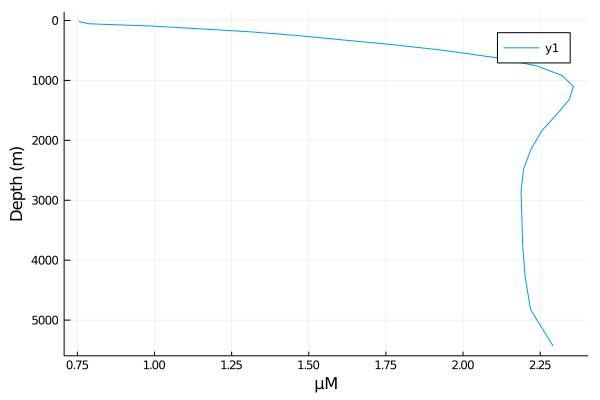

In [13]:
using Plots
plothorizontalmean(DIP * u"mol/m^3" .|> u"μM", grd)

We can plot the concentration of DIP at a given depth via, e.g.,

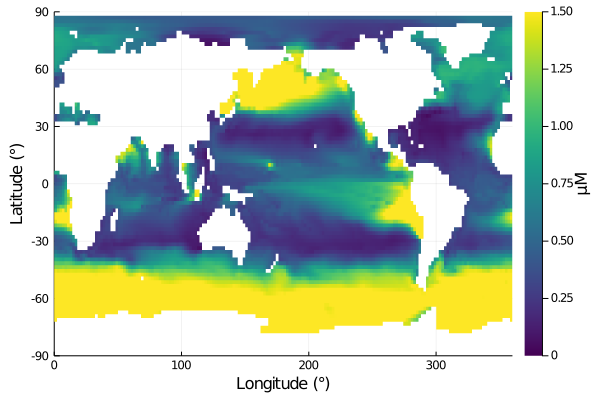

In [14]:
plothorizontalslice(DIP * u"mol/m^3" .|> u"μM", grd, depth=10u"m", color=:viridis, levels=range(0.0, 2.5, length = 6), clim=(0.0,1.5))

Or have a look at a map of the uptake at the surface

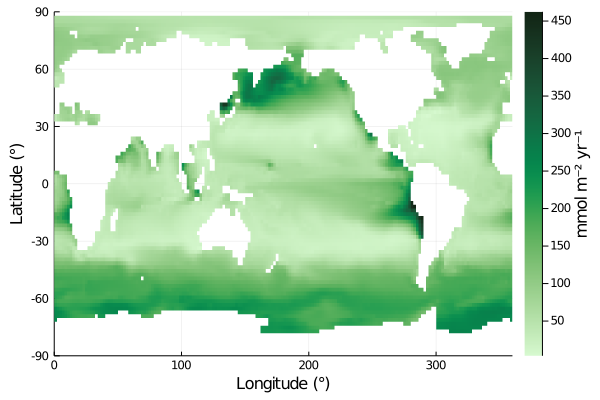

In [15]:
plotverticalintegral(U(DIP,p) * u"mol/m^3/s" .|> u"mmol/yr/m^3", grd, color=:algae)

Or look at what is exported below 500 m

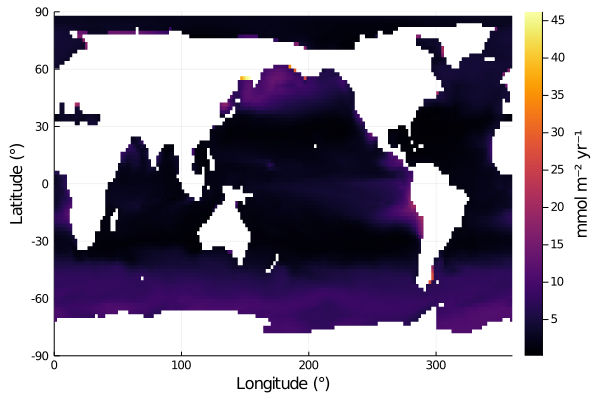

In [16]:
plothorizontalslice(POP .* w(z,p) * u"mol/m^3*m/s" .|> u"mmol/yr/m^2", grd, depth=500u"m", color=:inferno, rev=true)